In [12]:
# =========================================================
# Clean VAE Imputation + MB Pipeline (base + group-aware)
# =========================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


# =========================================================
# 0) Global settings
# =========================================================
cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

x_dim = 20
hidden_dim = 128
latent_dim = 16
lr = 1e-3
epochs = 30
batch_size = 100
beta = 1.0
m_draws = 20
seed = 0


METHODS_BASE = ["zero", "enc_ind", "enc_dec_ind"]
METHODS_GROUP = ["zero", "enc_ind", "enc_dec_ind",
                 "g_enc", "g_enc_ind", "g_enc_dec_ind"]


# =========================================================
# 1) Data loading + sanity checks
# =========================================================
def read_csv_matrix(path, dtype="float32"):
    return pd.read_csv(path).to_numpy().astype(dtype)

def scenario_has_group(prefix, base_dir):
    return os.path.exists(os.path.join(base_dir, f"{prefix}_group.csv"))

def load_scenario_arrays(prefix, base_dir, mask_in_csv_is_missing=True):
    """
    Loads:
      {prefix}_X_full.csv
      {prefix}_X_obs.csv
      {prefix}_mask.csv
      (optional) {prefix}_group.csv

    Returns:
      x_full, x_obs, mask_obs, group (or None)
    """
    x_full_path = os.path.join(base_dir, f"{prefix}_X_full.csv")
    x_obs_path  = os.path.join(base_dir, f"{prefix}_X_obs.csv")
    mask_path   = os.path.join(base_dir, f"{prefix}_mask.csv")
    group_path  = os.path.join(base_dir, f"{prefix}_group.csv")

    x_full = read_csv_matrix(x_full_path, dtype="float32")
    x_obs  = read_csv_matrix(x_obs_path, dtype="float32")
    mask_raw = pd.read_csv(mask_path).to_numpy()

    # normalize mask to 0/1
    mask_raw = (mask_raw != 0).astype("float32")

    # R export: 1=missing -> convert to 1=observed
    mask_obs = 1.0 - mask_raw if mask_in_csv_is_missing else mask_raw

    # sanitize x_obs
    x_obs = np.nan_to_num(x_obs, nan=0.0)
    x_obs = np.where(mask_obs == 1, x_obs, 0.0)

    # sanity checks
    assert x_full.shape == x_obs.shape == mask_obs.shape, f"[{prefix}] shape mismatch!"
    assert np.isfinite(x_obs).all(), f"[{prefix}] x_obs still has NaN/inf!"
    assert ((mask_obs == 0) | (mask_obs == 1)).all(), f"[{prefix}] mask not binary!"

    obs_rate = float(mask_obs.mean())
    miss_rate = 1.0 - obs_rate
    print(f"[{prefix}] observed≈{obs_rate:.3f} | missing≈{miss_rate:.3f}")

    group = None
    if os.path.exists(group_path):
        g = pd.read_csv(group_path)["group"].to_numpy().astype("int64")
        assert len(g) == x_full.shape[0], f"[{prefix}] group length mismatch!"
        group = g
        print(f"[{prefix}] group loaded: {np.unique(group)}")

    return x_full, x_obs, mask_obs, group


def make_loaders_from_arrays(x_full, x_obs, mask_obs, group=None,
                             batch_size=100, test_frac=1/3, seed=0):
    """
    Splits into train/test and returns DataLoaders.
    """
    x_full_t = torch.from_numpy(x_full).float()
    x_obs_t  = torch.from_numpy(x_obs).float()
    mask_t   = torch.from_numpy(mask_obs).float()

    N = x_full_t.shape[0]
    gen = torch.Generator().manual_seed(seed)
    test_mask = torch.rand(N, generator=gen) < test_frac

    x_full_test, x_full_train = x_full_t[test_mask], x_full_t[~test_mask]
    x_obs_test,  x_obs_train  = x_obs_t [test_mask], x_obs_t [~test_mask]
    mask_test,   mask_train   = mask_t  [test_mask], mask_t  [~test_mask]

    if group is not None:
        group_t = torch.from_numpy(group).long()
        group_test, group_train = group_t[test_mask], group_t[~test_mask]
        train_ds = TensorDataset(x_obs_train, x_full_train, mask_train, group_train)
        test_ds  = TensorDataset(x_obs_test,  x_full_test,  mask_test,  group_test)
    else:
        train_ds = TensorDataset(x_obs_train, x_full_train, mask_train)
        test_ds  = TensorDataset(x_obs_test,  x_full_test,  mask_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, test_loader


def load_scenario(prefix, base_dir, batch_size=100, seed=0, mask_in_csv_is_missing=True):
    x_full, x_obs, mask_obs, group = load_scenario_arrays(
        prefix, base_dir, mask_in_csv_is_missing=mask_in_csv_is_missing
    )
    train_loader, test_loader = make_loaders_from_arrays(
        x_full, x_obs, mask_obs, group=group,
        batch_size=batch_size, seed=seed
    )
    return train_loader, test_loader


# =========================================================
# 2) Input building (base + group-aware)
# =========================================================
def get_dims(method, x_dim):
    """
    returns: enc_input_dim, dec_cond_dim
    """
    if method == "zero":
        return x_dim, 0
    if method == "enc_ind":
        return 2 * x_dim, 0
    if method == "enc_dec_ind":
        return 2 * x_dim, x_dim

    if method == "g_enc":
        return x_dim + 1, 0
    if method == "g_enc_ind":
        return 2 * x_dim + 1, 0
    if method == "g_enc_dec_ind":
        return 2 * x_dim + 1, x_dim + 1

    raise ValueError(f"Unknown method: {method}")


def build_inputs(x_obs, mask, method, group=None):
    """
    x_obs: [B, I]
    mask:  [B, I] (1=observed, 0=missing)
    group: [B] int {0,1} or None
    """
    g = None
    if group is not None:
        g = group.float().unsqueeze(1)  # [B,1]

    if method == "zero":
        enc_inp = x_obs
        dec_cond = None

    elif method == "enc_ind":
        enc_inp = torch.cat([x_obs, mask], dim=1)
        dec_cond = None

    elif method == "enc_dec_ind":
        enc_inp = torch.cat([x_obs, mask], dim=1)
        dec_cond = mask

    elif method == "g_enc":
        if g is None:
            raise ValueError("g_enc requires group")
        enc_inp = torch.cat([x_obs, g], dim=1)
        dec_cond = None

    elif method == "g_enc_ind":
        if g is None:
            raise ValueError("g_enc_ind requires group")
        enc_inp = torch.cat([x_obs, mask, g], dim=1)
        dec_cond = None

    elif method == "g_enc_dec_ind":
        if g is None:
            raise ValueError("g_enc_dec_ind requires group")
        enc_inp = torch.cat([x_obs, mask, g], dim=1)
        dec_cond = torch.cat([mask, g], dim=1)

    else:
        raise ValueError(f"Unknown method: {method}")

    return enc_inp, dec_cond


# =========================================================
# 3) Model (Encoder / Decoder / VAE)
# =========================================================
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.FC1 = nn.Linear(input_dim, hidden_dim)
        self.FC2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_logvar = nn.Linear(hidden_dim, latent_dim)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.act(self.FC1(x))
        h = self.act(self.FC2(h))
        mean = self.FC_mean(h)
        log_var = self.FC_logvar(h)
        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, cond_dim=0):
        super().__init__()
        self.cond_dim = cond_dim
        in_dim = latent_dim + cond_dim

        self.FC1 = nn.Linear(in_dim, hidden_dim)
        self.FC2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_out = nn.Linear(hidden_dim, output_dim)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, z, cond=None):
        if self.cond_dim > 0:
            if cond is None:
                raise ValueError("Decoder requires cond but got None")
            z = torch.cat([z, cond], dim=1)

        h = self.act(self.FC1(z))
        h = self.act(self.FC2(h))
        return torch.sigmoid(self.FC_out(h))


class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparam(self, mean, log_var):
        log_var = torch.clamp(log_var, -10.0, 10.0)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + std * eps

    def forward(self, enc_inp, dec_cond=None):
        mean, log_var = self.encoder(enc_inp)
        z = self.reparam(mean, log_var)
        x_hat = self.decoder(z, cond=dec_cond)
        return x_hat, mean, log_var


# =========================================================
# 4) Losses + training
# =========================================================
def masked_bce(x_hat, x_target, mask):
    bce = F.binary_cross_entropy(x_hat, x_target, reduction="none")
    return (bce * mask).sum() / (mask.sum() + 1e-8)

def missing_bce(x_hat, x_target, mask):
    bce = F.binary_cross_entropy(x_hat, x_target, reduction="none")
    miss = 1.0 - mask
    return (bce * miss).sum() / (miss.sum() + 1e-8)

def kld_loss(mean, log_var):
    return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / mean.size(0)

def missing_rmse(p_hat, x_full, mask):
    miss = 1.0 - mask
    se = (p_hat - x_full) ** 2
    return torch.sqrt((se * miss).sum() / (miss.sum() + 1e-8))


import copy
import numpy as np
import torch

def train_one_method(
    method, train_loader, test_loader,
    x_dim=20, hidden_dim=128, latent_dim=16,
    lr=3e-4, epochs=30, device="cpu",
    beta_max=1.0, warmup_epochs=10,
    weight_decay=1e-5,
    patience=5, min_delta=1e-4,
    clip_grad=5.0,
    verbose=True
):
    """
    Improvements:
      - Early stopping on test_missing_bce (validation)
      - Save best checkpoint (state_dict)
      - ReduceLROnPlateau scheduler on test_missing_bce
      - KL warm-up: beta(t) increases linearly from 0 to beta_max
      - weight decay for regularization

    Returns:
      best_model, history (history includes best_epoch/best_score)
    """

    # ---- build model ----
    enc_input_dim, dec_cond_dim = get_dims(method, x_dim)
    encoder = Encoder(enc_input_dim, hidden_dim, latent_dim)
    decoder = Decoder(latent_dim, hidden_dim, x_dim, cond_dim=dec_cond_dim)
    model = VAE(encoder, decoder).to(device)

    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim, mode="min", factor=0.5, patience=2
    )

    history = {
        "train_missing_bce": [],
        "test_missing_bce": [],
        "train_obs_recon": [],
        "test_obs_recon": [],
        "train_kld": [],
        "test_kld": [],
        "lr": [],
        "beta": [],
        "best_epoch": None,
        "best_test_missing_bce": None
    }

    best_state = None
    best_score = float("inf")
    best_epoch = -1
    bad_epochs = 0

    for ep in range(epochs):
        # ---- KL warm-up ----
        if warmup_epochs and warmup_epochs > 0:
            beta = beta_max * min(1.0, (ep + 1) / warmup_epochs)
        else:
            beta = beta_max
        history["beta"].append(beta)

        # =========================
        # Train
        # =========================
        model.train()
        train_miss_vals = []
        train_obs_vals = []
        train_kld_vals = []

        for batch in train_loader:
            if len(batch) == 3:
                x_obs, x_full, mask = batch
                group = None
            else:
                x_obs, x_full, mask, group = batch

            x_obs  = x_obs.to(device).float()
            x_full = x_full.to(device).float()
            mask   = mask.to(device).float()
            group  = group.to(device) if group is not None else None

            enc_inp, dec_cond = build_inputs(x_obs, mask, method, group=group)

            optim.zero_grad()
            x_hat, mean, log_var = model(enc_inp, dec_cond)

            obs_recon = masked_bce(x_hat, x_full, mask)
            kld = kld_loss(mean, log_var)
            loss = obs_recon + beta * kld

            loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optim.step()

            # metrics
            train_miss_vals.append(missing_bce(x_hat.detach(), x_full, mask).item())
            train_obs_vals.append(obs_recon.detach().item())
            train_kld_vals.append(kld.detach().item())

        train_missing = float(np.mean(train_miss_vals))
        train_obs = float(np.mean(train_obs_vals))
        train_kld = float(np.mean(train_kld_vals))

        # =========================
        # Eval (test/val)
        # =========================
        model.eval()
        test_miss_vals = []
        test_obs_vals = []
        test_kld_vals = []

        with torch.no_grad():
            for batch in test_loader:
                if len(batch) == 3:
                    x_obs, x_full, mask = batch
                    group = None
                else:
                    x_obs, x_full, mask, group = batch

                x_obs  = x_obs.to(device).float()
                x_full = x_full.to(device).float()
                mask   = mask.to(device).float()
                group  = group.to(device) if group is not None else None

                enc_inp, dec_cond = build_inputs(x_obs, mask, method, group=group)
                x_hat, mean, log_var = model(enc_inp, dec_cond)

                obs_recon = masked_bce(x_hat, x_full, mask)
                kld = kld_loss(mean, log_var)

                test_miss_vals.append(missing_bce(x_hat, x_full, mask).item())
                test_obs_vals.append(obs_recon.item())
                test_kld_vals.append(kld.item())

        test_missing = float(np.mean(test_miss_vals))
        test_obs = float(np.mean(test_obs_vals))
        test_kld = float(np.mean(test_kld_vals))

        # ---- scheduler step on validation metric ----
        scheduler.step(test_missing)

        # ---- record ----
        history["train_missing_bce"].append(train_missing)
        history["test_missing_bce"].append(test_missing)
        history["train_obs_recon"].append(train_obs)
        history["test_obs_recon"].append(test_obs)
        history["train_kld"].append(train_kld)
        history["test_kld"].append(test_kld)
        history["lr"].append(float(optim.param_groups[0]["lr"]))

        if verbose:
            print(
                f"[{method}] Ep{ep+1:02d} | "
                f"beta={beta:.3f} | lr={optim.param_groups[0]['lr']:.2e} | "
                f"train miss={train_missing:.4f} test miss={test_missing:.4f} | "
                f"train obs={train_obs:.4f} test obs={test_obs:.4f} | "
                f"test kld={test_kld:.4f}"
            )

        # =========================
        # Early stopping + best ckpt
        # =========================
        if test_missing < best_score - min_delta:
            best_score = test_missing
            best_epoch = ep
            bad_epochs = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                if verbose:
                    print(f"[{method}] Early stop at epoch {ep+1}, best epoch={best_epoch+1}, best test miss={best_score:.4f}")
                break

    # ---- load best ----
    if best_state is not None:
        model.load_state_dict(best_state)

    history["best_epoch"] = int(best_epoch + 1) if best_epoch >= 0 else None
    history["best_test_missing_bce"] = float(best_score) if np.isfinite(best_score) else None
    return model, history


def predict_probs(model, method, loader, device):
    model.eval()
    all_p, all_g = [], []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                x_obs, x_full, mask = batch
                group = None
            else:
                x_obs, x_full, mask, group = batch

            x_obs = x_obs.to(device).float()
            mask  = mask.to(device).float()
            group = group.to(device) if group is not None else None

            enc_inp, dec_cond = build_inputs(x_obs, mask, method, group=group)
            x_hat, _, _ = model(enc_inp, dec_cond)

            all_p.append(x_hat.detach().cpu())
            if group is not None:
                all_g.append(group.detach().cpu())

    P_hat = torch.cat(all_p, dim=0)
    G = torch.cat(all_g, dim=0) if len(all_g) > 0 else None
    return P_hat, G


# =========================================================
# 5) MB reporting utils
# =========================================================
def expected_scores(P_hat):
    exp_pc = P_hat.mean(dim=1)
    exp_ts = P_hat.sum(dim=1)
    return exp_pc, exp_ts

def mi_draw_scores(P_hat, m=20, seed=0):
    g = torch.Generator(device=P_hat.device).manual_seed(seed)
    pc_list, ts_list = [], []
    for _ in range(m):
        X_draw = torch.bernoulli(P_hat, generator=g)
        pc_list.append(X_draw.mean(dim=1))
        ts_list.append(X_draw.sum(dim=1))
    return torch.stack(pc_list, dim=0), torch.stack(ts_list, dim=0)

def rubin_combine(estimates, variances):
    m = len(estimates)
    Q_bar = estimates.mean()
    U_bar = variances.mean()
    B = estimates.var(ddof=1)
    T = U_bar + (1 + 1/m) * B
    return Q_bar, T

def group_stats_expected(score, group=None, include_all=True):
    """
    Returns a list of rows.
    If group is provided and include_all=True, returns:
      - ALL row
      - each group row
    """
    score_np = score.detach().cpu().numpy()
    out = []

    if include_all:
        out.append({
            "group": "ALL",
            "n": int(len(score_np)),
            "mean": float(score_np.mean()),
            "sd": float(score_np.std(ddof=1))
        })

    if group is None:
        return out

    group_np = group.detach().cpu().numpy()
    for g in np.unique(group_np):
        idx = (group_np == g)
        out.append({
            "group": int(g),
            "n": int(idx.sum()),
            "mean": float(score_np[idx].mean()),
            "sd": float(score_np[idx].std(ddof=1))
        })
    return out


def group_stats_mi(score_draws, group=None, include_all=True):
    """
    score_draws: torch [m, N]
    Returns list of rows:
      - ALL row (Rubin combine over overall mean per draw)
      - per-group rows (Rubin combine over group means per draw)
    """
    score_np = score_draws.detach().cpu().numpy()  # [m, N]
    m, N = score_np.shape
    out = []

    def rubin_over_idx(idx):
        n = idx.sum()
        means = score_np[:, idx].mean(axis=1)               # [m]
        vars_mean = score_np[:, idx].var(axis=1, ddof=1) / max(n, 1)   # [m]
        Q_bar, T = rubin_combine(means, vars_mean)
        return int(n), float(Q_bar), float(np.sqrt(T))

    if include_all:
        idx_all = np.ones(N, dtype=bool)
        n_all, mean_all, se_all = rubin_over_idx(idx_all)
        out.append({"group": "ALL", "n": n_all, "MI_mean": mean_all, "MI_se": se_all})

    if group is None:
        return out

    group_np = group.detach().cpu().numpy()
    for g in np.unique(group_np):
        idx = (group_np == g)
        n_g, mean_g, se_g = rubin_over_idx(idx)
        out.append({"group": int(g), "n": n_g, "MI_mean": mean_g, "MI_se": se_g})

    return out


# =========================================================
# 6) Run one scenario
# =========================================================
def run_scenario(prefix, base_dir, dataset_tag="", device="cpu",
                 x_dim=20, hidden_dim=128, latent_dim=16,
                 lr=3e-4, epochs=30,
                 beta_max=1.0, warmup_epochs=10,
                 weight_decay=1e-5,
                 patience=5, min_delta=1e-4, clip_grad=5.0,
                 batch_size=100, m_draws=20, seed=0):

    has_group = scenario_has_group(prefix, base_dir)
    methods = METHODS_GROUP if has_group else METHODS_BASE

    print(f"\n=== Running scenario: {prefix} | has_group={has_group} | methods={methods} ===")

    train_loader, test_loader = load_scenario(
        prefix=prefix, base_dir=base_dir, batch_size=batch_size, seed=seed,
        mask_in_csv_is_missing=True
    )

    rows = []

    for method in methods:
        print(f"\n[{dataset_tag} | {prefix}] METHOD={method}")

        model, hist = train_one_method(
            method=method,
            train_loader=train_loader,
            test_loader=test_loader,
            x_dim=x_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            lr=lr,
            epochs=epochs,
            device=device,
            beta_max=beta_max,
            warmup_epochs=warmup_epochs,
            weight_decay=weight_decay,
            patience=patience,
            min_delta=min_delta,
            clip_grad=clip_grad,
            verbose=True
        )

        P_hat, G = predict_probs(model, method, test_loader, device)
        P_hat = P_hat.to(device)
        if G is not None:
            G = G.to(device)

        # aligned x_full_test + mask_test
        x_full_list, mask_list = [], []
        with torch.no_grad():
            for batch in test_loader:
                if len(batch) == 3:
                    _, x_full, mask = batch
                else:
                    _, x_full, mask, _ = batch
                x_full_list.append(x_full)
                mask_list.append(mask)

        x_full_test = torch.cat(x_full_list, dim=0).to(device).float()
        mask_test   = torch.cat(mask_list, dim=0).to(device).float()

        bce_miss  = float(missing_bce(P_hat, x_full_test, mask_test).item())
        rmse_miss = float(missing_rmse(P_hat, x_full_test, mask_test).item())

        # MB
        exp_pc, exp_ts = expected_scores(P_hat)
        pc_draws, ts_draws = mi_draw_scores(P_hat, m=m_draws, seed=seed)

        exp_pc_stats = group_stats_expected(exp_pc, group=G, include_all=True)
        exp_ts_stats = group_stats_expected(exp_ts, group=G, include_all=True)
        mi_pc_stats  = group_stats_mi(pc_draws, group=G, include_all=True)
        mi_ts_stats  = group_stats_mi(ts_draws, group=G, include_all=True)

        # align by group key
        exp_pc_map = {str(r["group"]): r for r in exp_pc_stats}
        exp_ts_map = {str(r["group"]): r for r in exp_ts_stats}
        mi_pc_map  = {str(r["group"]): r for r in mi_pc_stats}
        mi_ts_map  = {str(r["group"]): r for r in mi_ts_stats}

        group_keys = sorted(exp_pc_map.keys(), key=lambda x: (x != "ALL", x))

        for gk in group_keys:
            rows.append({
                "DatasetTag": dataset_tag,
                "Scenario": prefix,
                "METHOD": method,
                "Group": exp_pc_map[gk]["group"],
                "n": exp_pc_map[gk]["n"],

                "Missing_BCE": bce_miss,
                "Missing_RMSE": rmse_miss,

                "Expected_PC_mean": exp_pc_map[gk]["mean"],
                "Expected_PC_sd": exp_pc_map[gk]["sd"],
                "MI_PC_mean": mi_pc_map[gk]["MI_mean"],
                "MI_PC_se": mi_pc_map[gk]["MI_se"],

                "Expected_TS_mean": exp_ts_map[gk]["mean"],
                "Expected_TS_sd": exp_ts_map[gk]["sd"],
                "MI_TS_mean": mi_ts_map[gk]["MI_mean"],
                "MI_TS_se": mi_ts_map[gk]["MI_se"],

                # use BEST, not last
                "Final_test_missing_BCE_trainingcurve": hist["best_test_missing_bce"],
                "has_group": has_group,
                "best_epoch": hist["best_epoch"]
            })

    return pd.DataFrame(rows)


def run_suite(base_dir, scenarios, dataset_tag, device,
              x_dim=20, hidden_dim=128, latent_dim=16,
              lr=3e-4, epochs=30,
              beta_max=1.0, warmup_epochs=10,
              weight_decay=1e-5,
              patience=5, min_delta=1e-4, clip_grad=5.0,
              batch_size=100, m_draws=20, seed=0):

    dfs = []
    for s in scenarios:
        df = run_scenario(
            prefix=s,
            base_dir=base_dir,
            dataset_tag=dataset_tag,
            device=device,
            x_dim=x_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            lr=lr,
            epochs=epochs,
            beta_max=beta_max,
            warmup_epochs=warmup_epochs,
            weight_decay=weight_decay,
            patience=patience,
            min_delta=min_delta,
            clip_grad=clip_grad,
            batch_size=batch_size,
            m_draws=m_draws,
            seed=seed
        )
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# =========================================================
# 8) MAIN RUN
# =========================================================
base_dir_ext = os.path.expanduser("~/Desktop")
scenarios_ext = [
    "MNAR_Y1", "MNAR_Y2",
    "NR_simple", "NR_speed",
    "Booklet50_MCAR20",
    "DIFMCAR60", "DIFMNARth60",
    "GroupMAR60"
]

base_dir_mech = os.path.expanduser("~/Desktop/sem2/irtimputation/mach")
scenarios_mech = ["MCAR60", "MAR60", "MNAR60"]

base_dir_rate = os.path.expanduser("~/Desktop/sem2/irtimputation")
scenarios_rate = ["MCAR40", "MCAR50", "MCAR60", "MCAR70"]

suite_cfg = dict(
    x_dim=20,
    hidden_dim=128,
    latent_dim=16,
    lr=3e-4,
    epochs=30,
    beta_max=1.0,
    warmup_epochs=10,
    weight_decay=1e-5,
    patience=5,
    min_delta=1e-4,
    clip_grad=5.0,
    batch_size=100,
    m_draws=20,
    seed=0
)

df_ext  = run_suite(base_dir_ext,  scenarios_ext,  dataset_tag="Extended",    device=DEVICE, **suite_cfg)
df_mech = run_suite(base_dir_mech, scenarios_mech, dataset_tag="Mechanism60", device=DEVICE, **suite_cfg)
df_rate = run_suite(base_dir_rate, scenarios_rate, dataset_tag="MCAR_rate",   device=DEVICE, **suite_cfg)

df_all = pd.concat([df_ext, df_mech, df_rate], ignore_index=True)

out_path = "VAE_MB_results_ALL.csv"
df_all.to_csv(out_path, index=False)
print("\nSaved:", out_path)

df_all



=== Running scenario: MNAR_Y1 | has_group=False | methods=['zero', 'enc_ind', 'enc_dec_ind'] ===
[MNAR_Y1] observed≈0.403 | missing≈0.597

[Extended | MNAR_Y1] METHOD=zero
[zero] Ep01 | beta=0.100 | lr=3.00e-04 | train miss=0.6946 test miss=0.6861 | train obs=0.6792 test obs=0.6529 | test kld=0.0129
[zero] Ep02 | beta=0.200 | lr=3.00e-04 | train miss=0.6807 test miss=0.6722 | train obs=0.6313 test obs=0.5975 | test kld=0.0079
[zero] Ep03 | beta=0.300 | lr=3.00e-04 | train miss=0.6746 test miss=0.6764 | train obs=0.5763 test obs=0.5443 | test kld=0.0044
[zero] Ep04 | beta=0.400 | lr=3.00e-04 | train miss=0.6864 test miss=0.6984 | train obs=0.5391 test obs=0.5169 | test kld=0.0025
[zero] Ep05 | beta=0.500 | lr=1.50e-04 | train miss=0.7068 test miss=0.7057 | train obs=0.5244 test obs=0.5082 | test kld=0.0020
[zero] Ep06 | beta=0.600 | lr=1.50e-04 | train miss=0.7146 test miss=0.7057 | train obs=0.5210 test obs=0.5060 | test kld=0.0017
[zero] Ep07 | beta=0.700 | lr=1.50e-04 | train miss=0

,DatasetTag,Scenario,METHOD,Group,n,Missing_BCE,Missing_RMSE,Expected_PC_mean,Expected_PC_sd,MI_PC_mean,MI_PC_se,Expected_TS_mean,Expected_TS_sd,MI_TS_mean,MI_TS_se,Final_test_missing_BCE_trainingcurve,has_group,best_epoch
0,Extended,MNAR_Y1,zero,ALL,1008,0.674968,0.491127,0.582388,0.016293,0.581354,0.005322,11.647761,0.325865,11.627084,0.106436,0.672236,False,2
1,Extended,MNAR_Y1,enc_ind,ALL,1008,0.672644,0.490163,0.631635,0.024190,0.630541,0.005069,12.632708,0.483794,12.610814,0.101375,0.667306,False,3
2,Extended,MNAR_Y1,enc_dec_ind,ALL,1008,0.665314,0.486386,0.577372,0.014201,0.576074,0.005536,11.547440,0.284010,11.521479,0.110725,0.664725,False,2
3,Extended,MNAR_Y2,zero,ALL,1008,0.706184,0.506432,0.538250,0.008607,0.536696,0.005320,10.764995,0.172138,10.733930,0.106398,0.704902,False,1
4,Extended,MNAR_Y2,enc_ind,ALL,1008,0.704779,0.505750,0.543902,0.008956,0.542584,0.005417,10.878036,0.179117,10.851686,0.108350,0.703186,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,MCAR_rate,MCAR60,enc_ind,ALL,1008,0.625314,0.467106,0.507697,0.005052,0.507071,0.004728,10.153946,0.101036,10.141418,0.094564,0.625595,False,13
86,MCAR_rate,MCAR60,enc_dec_ind,ALL,1008,0.625926,0.467346,0.508012,0.005600,0.507378,0.005055,10.160238,0.111993,10.147570,0.101099,0.626733,False,9
87,MCAR_rate,MCAR70,zero,ALL,1008,0.603740,0.456103,0.501897,0.003363,0.501195,0.005406,10.037935,0.067254,10.023909,0.108123,0.601072,False,15
88,MCAR_rate,MCAR70,enc_ind,ALL,1008,0.604282,0.456304,0.501456,0.004497,0.500675,0.005344,10.029126,0.089932,10.013492,0.106889,0.601779,False,20


In [17]:
out_path = "VAE_MB_results_new.csv"
df_all.to_csv(out_path, index=False)
print("\nSaved:", out_path)


Saved: VAE_MB_results_new.csv


In [18]:
import pandas as pd
df_all = pd.read_csv("VAE_MB_results_new.csv")

df_cmp shape: (69, 6)
methods present: ['IRT' 'zero' 'enc_ind' 'enc_dec_ind' 'g_enc' 'g_enc_ind' 'g_enc_dec_ind']

[Missing_BCE (IRT+VAE)] NaN cells: 36
Rows with NaN: ['MCAR40', 'Booklet50_MCAR20', 'NR_simple', 'MCAR60_mech', 'MAR60', 'NR_speed', 'MCAR70', 'MCAR50', 'MCAR60', 'MNAR60', 'MNAR_Y1', 'MNAR_Y2']
Cols with NaN: ['g_enc', 'g_enc_ind', 'g_enc_dec_ind']

[Expected_PC_mean (VAE only)] NaN cells: 36
Rows with NaN: ['MCAR40', 'Booklet50_MCAR20', 'NR_simple', 'MCAR60_mech', 'MAR60', 'NR_speed', 'MCAR70', 'MCAR50', 'MCAR60', 'MNAR60', 'MNAR_Y1', 'MNAR_Y2']
Cols with NaN: ['g_enc', 'g_enc_ind', 'g_enc_dec_ind']

[Expected_TS_mean (VAE only)] NaN cells: 36
Rows with NaN: ['MCAR40', 'Booklet50_MCAR20', 'NR_simple', 'MCAR60_mech', 'MAR60', 'NR_speed', 'MCAR70', 'MCAR50', 'MCAR60', 'MNAR60', 'MNAR_Y1', 'MNAR_Y2']
Cols with NaN: ['g_enc', 'g_enc_ind', 'g_enc_dec_ind']


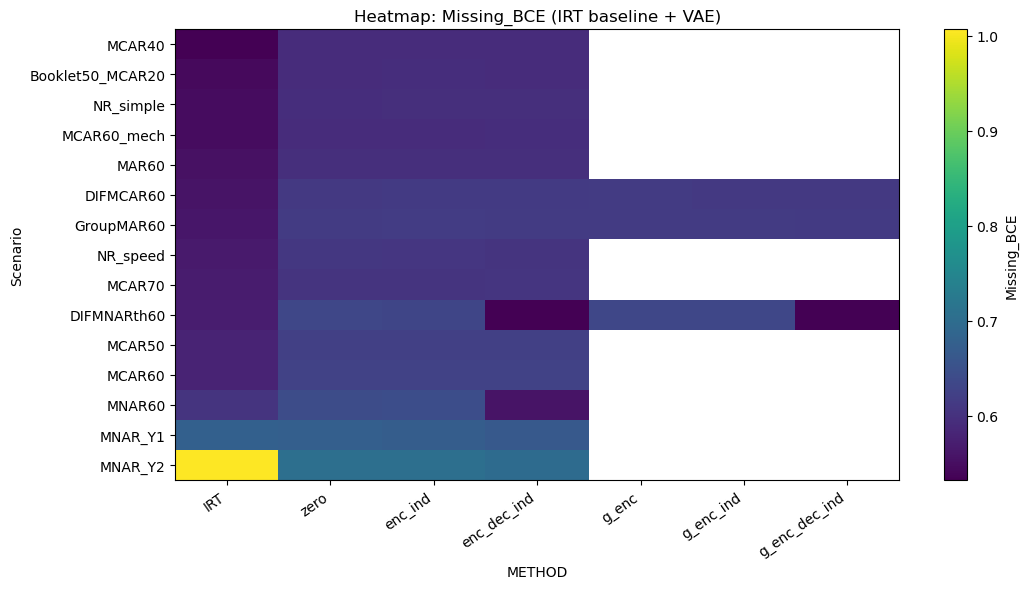

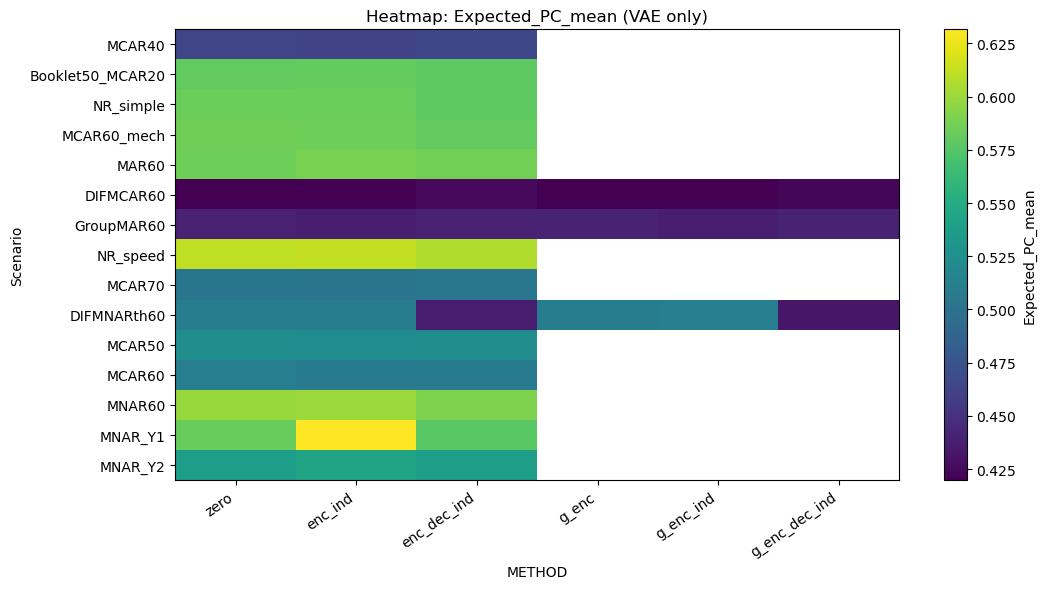

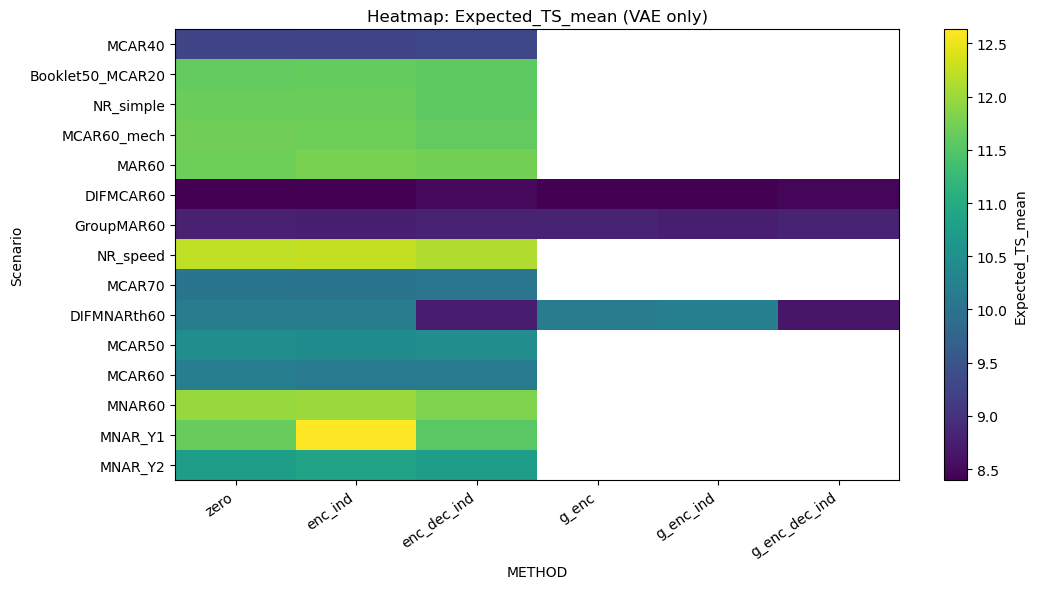

/var/folders/5g/72gqgnfj2sb5v02yx26tbl1h0000gn/T/ipykernel_13801/3485303514.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = (df_plot.groupby("METHOD", as_index=False)[metric].mean()


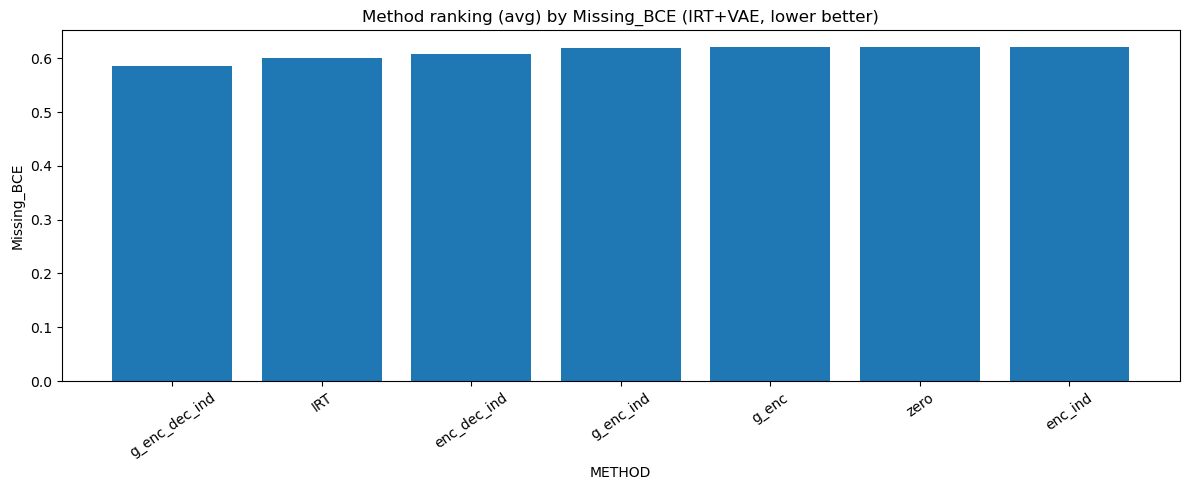

In [19]:
# =========================================================
# VAE + IRT merge + plotting (final)
# Metrics: Missing_BCE / Missing_RMSE / Expected_PC_mean / Expected_TS_mean
# - Heatmaps include IRT for Missing_BCE/RMSE
# - PC/TS heatmaps: VAE only (IRT has no PC/TS)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Your IRT baseline df
# -----------------------------
df_irt = pd.DataFrame([
    {"Scenario":"MCAR40",          "MissingRate":0.4, "Missing_RMSE":0.4231, "Missing_BCE":0.5321},
    {"Scenario":"Booklet50_MCAR20","MissingRate":0.6, "Missing_RMSE":0.4288, "Missing_BCE":0.5447},
    {"Scenario":"NR_simple",       "MissingRate":0.6, "Missing_RMSE":0.4304, "Missing_BCE":0.5485},
    {"Scenario":"MCAR60_mech",     "MissingRate":0.6, "Missing_RMSE":0.4307, "Missing_BCE":0.5486},
    {"Scenario":"MAR60",           "MissingRate":0.6, "Missing_RMSE":0.4324, "Missing_BCE":0.5530},
    {"Scenario":"DIFMCAR60",       "MissingRate":0.6, "Missing_RMSE":0.4354, "Missing_BCE":0.5570},
    {"Scenario":"GroupMAR60",      "MissingRate":0.6, "Missing_RMSE":0.4371, "Missing_BCE":0.5604},
    {"Scenario":"NR_speed",        "MissingRate":0.6, "Missing_RMSE":0.4384, "Missing_BCE":0.5659},
    {"Scenario":"MCAR70",          "MissingRate":0.7, "Missing_RMSE":0.4403, "Missing_BCE":0.5689},
    {"Scenario":"DIFMNARth60",     "MissingRate":0.6, "Missing_RMSE":0.4426, "Missing_BCE":0.5707},
    {"Scenario":"MCAR50",          "MissingRate":0.5, "Missing_RMSE":0.4452, "Missing_BCE":0.5792},
    {"Scenario":"MCAR60",          "MissingRate":0.6, "Missing_RMSE":0.4455, "Missing_BCE":0.5797},
    {"Scenario":"MNAR60",          "MissingRate":0.6, "Missing_RMSE":0.4529, "Missing_BCE":0.6041},
    {"Scenario":"MNAR_Y1",         "MissingRate":0.6, "Missing_RMSE":0.4848, "Missing_BCE":0.6784},
    {"Scenario":"MNAR_Y2",         "MissingRate":0.6, "Missing_RMSE":0.5887, "Missing_BCE":1.0065},
])

# -----------------------------
# 1) Load + unify VAE "ALL"
# -----------------------------
def prepare_vae_table(
    vae_path: str,
    scenario_order: list,
    method_order_vae: list,
    mech_mcar60_name="MCAR60_mech",
    base_mech_tag="Mechanism60",
):
    df = pd.read_csv(vae_path)

    # merge name for mechanism MCAR60
    df["Scenario_merged"] = df["Scenario"].astype(str)
    df.loc[
        (df["DatasetTag"].astype(str) == base_mech_tag) &
        (df["Scenario"].astype(str) == "MCAR60"),
        "Scenario_merged"
    ] = mech_mcar60_name

    value_cols = ["Missing_BCE","Missing_RMSE","Expected_PC_mean","Expected_TS_mean"]
    missing_cols = [c for c in value_cols + ["Scenario_merged","METHOD"] if c not in df.columns]
    if missing_cols:
        raise ValueError(f"VAE CSV missing columns: {missing_cols}\nColumns are: {df.columns.tolist()}")

    # build ALL-like by averaging over groups per (scenario, method)
    df_plot = (
        df.groupby(["Scenario_merged","METHOD"], as_index=False)[value_cols]
          .mean()
    )

    # categorical order
    df_plot["Scenario_merged"] = pd.Categorical(df_plot["Scenario_merged"], categories=scenario_order, ordered=True)
    df_plot["METHOD"] = pd.Categorical(df_plot["METHOD"], categories=method_order_vae, ordered=True)
    df_plot = df_plot.sort_values(["Scenario_merged","METHOD"]).reset_index(drop=True)
    return df_plot


# -----------------------------
# 2) Build IRT table in same schema
# -----------------------------
def prepare_irt_table(df_irt, scenario_order):
    df = df_irt.copy()
    df["Scenario_merged"] = df["Scenario"].astype(str)
    df["METHOD"] = "IRT"

    # add PC/TS placeholders (IRT doesn't have them)
    df["Expected_PC_mean"] = np.nan
    df["Expected_TS_mean"] = np.nan

    # keep same columns as VAE-plot table
    df = df[["Scenario_merged","METHOD","Missing_BCE","Missing_RMSE","Expected_PC_mean","Expected_TS_mean"]]
    df["Scenario_merged"] = pd.Categorical(df["Scenario_merged"], categories=scenario_order, ordered=True)
    return df


# -----------------------------
# 3) Pivot + checks + plots
# -----------------------------
def pivot_metric(df_plot, metric, scenario_order, method_order):
    pv = df_plot.pivot(index="Scenario_merged", columns="METHOD", values=metric)
    pv = pv.reindex(index=scenario_order, columns=method_order)
    return pv

def completeness_report(pv, name):
    nan_cells = int(pv.isna().sum().sum())
    rows_with_nan = pv.index[pv.isna().any(axis=1)].tolist()
    cols_with_nan = pv.columns[pv.isna().any(axis=0)].tolist()
    print(f"\n[{name}] NaN cells: {nan_cells}")
    if nan_cells > 0:
        print("Rows with NaN:", rows_with_nan)
        print("Cols with NaN:", cols_with_nan)

def plot_heatmap(pv, title, xlabel="METHOD", ylabel="Scenario"):
    fig, ax = plt.subplots(figsize=(11, 6))
    im = ax.imshow(pv.values, aspect="auto")

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_xticks(np.arange(pv.shape[1]))
    ax.set_xticklabels(pv.columns.astype(str), rotation=35, ha="right")
    ax.set_yticks(np.arange(pv.shape[0]))
    ax.set_yticklabels(pv.index.astype(str))

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(pv.name if pv.name else "")
    plt.tight_layout()
    plt.show()

def plot_method_ranking(df_plot, metric, title):
    fig, ax = plt.subplots(figsize=(12, 5))
    tmp = (df_plot.groupby("METHOD", as_index=False)[metric].mean()
                 .dropna()
                 .sort_values(metric, ascending=True))
    ax.bar(tmp["METHOD"].astype(str), tmp[metric].values)
    ax.set_title(title)
    ax.set_xlabel("METHOD")
    ax.set_ylabel(metric)
    ax.tick_params(axis="x", rotation=35)
    plt.tight_layout()
    plt.show()


# =========================================================
# 4) RUN
# =========================================================
vae_path = "VAE_MB_results_new.csv"  # <-- your VAE results

scenario_order = [
    "MCAR40",
    "Booklet50_MCAR20",
    "NR_simple",
    "MCAR60_mech",
    "MAR60",
    "DIFMCAR60",
    "GroupMAR60",
    "NR_speed",
    "MCAR70",
    "DIFMNARth60",
    "MCAR50",
    "MCAR60",
    "MNAR60",
    "MNAR_Y1",
    "MNAR_Y2",
]

method_order_vae = ["zero", "enc_ind", "enc_dec_ind", "g_enc", "g_enc_ind", "g_enc_dec_ind"]
method_order_cmp = ["IRT"] + method_order_vae  # include IRT for BCE/RMSE heatmaps

# ---- build tables ----
df_vae_plot = prepare_vae_table(
    vae_path=vae_path,
    scenario_order=scenario_order,
    method_order_vae=method_order_vae
)
df_irt_plot = prepare_irt_table(df_irt, scenario_order=scenario_order)

# combine
df_cmp = pd.concat([df_vae_plot, df_irt_plot], ignore_index=True)
df_cmp["METHOD"] = pd.Categorical(df_cmp["METHOD"].astype(str), categories=method_order_cmp, ordered=True)
df_cmp = df_cmp.sort_values(["Scenario_merged","METHOD"]).reset_index(drop=True)

print("df_cmp shape:", df_cmp.shape)
print("methods present:", df_cmp["METHOD"].dropna().astype(str).unique())

# ---- pivots (BCE/RMSE include IRT) ----
pv_bce  = pivot_metric(df_cmp, "Missing_BCE",  scenario_order, method_order_cmp); pv_bce.name  = "Missing_BCE"

# ---- pivots (PC/TS: VAE only) ----
pv_pc = pivot_metric(df_vae_plot, "Expected_PC_mean", scenario_order, method_order_vae); pv_pc.name = "Expected_PC_mean"
pv_ts = pivot_metric(df_vae_plot, "Expected_TS_mean", scenario_order, method_order_vae); pv_ts.name = "Expected_TS_mean"

# ---- check NaNs (white blocks in heatmap == NaN) ----
completeness_report(pv_bce,  "Missing_BCE (IRT+VAE)")
completeness_report(pv_pc,   "Expected_PC_mean (VAE only)")
completeness_report(pv_ts,   "Expected_TS_mean (VAE only)")

# ---- heatmaps ----
plot_heatmap(pv_bce,  "Heatmap: Missing_BCE (IRT baseline + VAE)")
plot_heatmap(pv_pc,   "Heatmap: Expected_PC_mean (VAE only)")
plot_heatmap(pv_ts,   "Heatmap: Expected_TS_mean (VAE only)")

# ---- optional: method ranking bars (includes IRT for BCE/RMSE) ----
plot_method_ranking(df_cmp, "Missing_BCE",  "Method ranking (avg) by Missing_BCE (IRT+VAE, lower better)")



[Heatmap: Δ Missing_BCE (VAE - IRT, negative is better)] NaN cells: 36
Rows with NaN: ['MCAR40', 'Booklet50_MCAR20', 'NR_simple', 'MCAR60_mech', 'MAR60', 'NR_speed', 'MCAR70', 'MCAR50', 'MCAR60', 'MNAR60', 'MNAR_Y1', 'MNAR_Y2']
Cols with NaN: ['g_enc', 'g_enc_ind', 'g_enc_dec_ind']


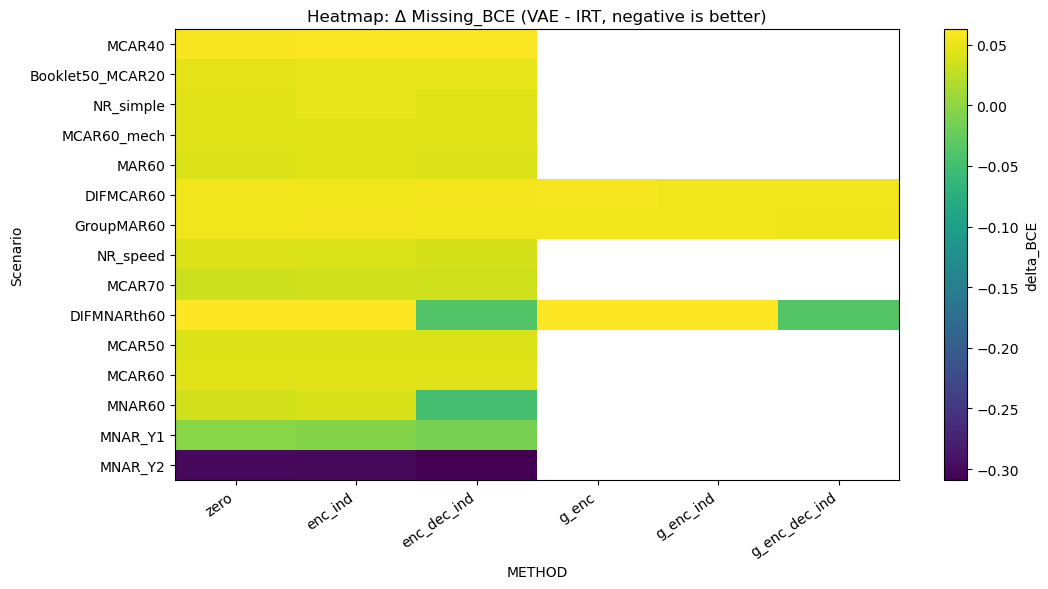

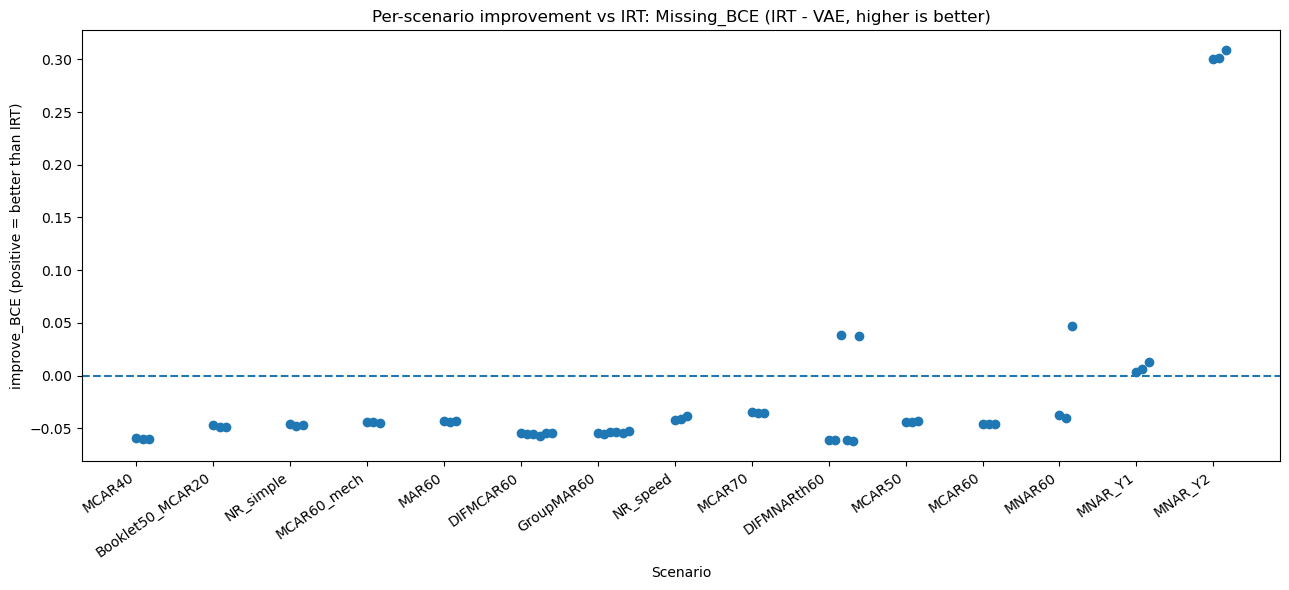

/var/folders/5g/72gqgnfj2sb5v02yx26tbl1h0000gn/T/ipykernel_13801/2512867851.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = (vae_delta_long.groupby("METHOD", as_index=False)[value_col]


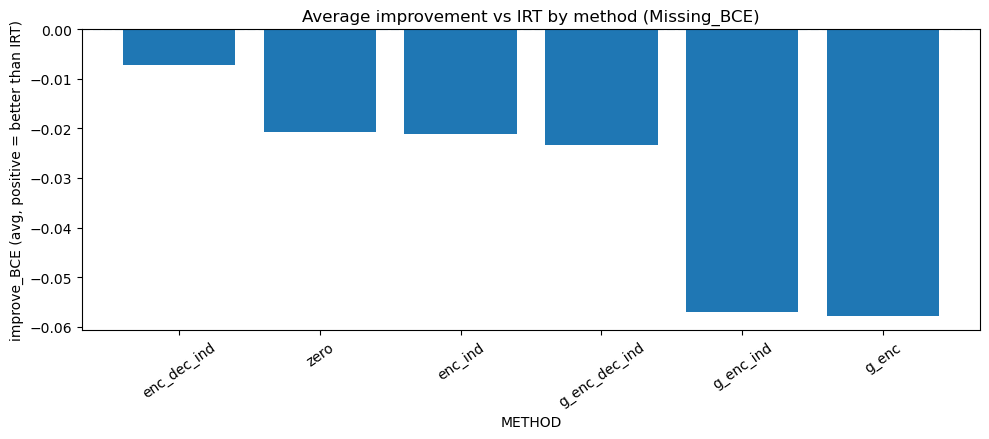

In [20]:
# =========================================================
# 5) Delta vs IRT (BCE/RMSE only)
# =========================================================

def delta_vs_irt_table(df_cmp, scenario_order, method_order_vae):
    """
    Return long table with columns:
      Scenario_merged, METHOD, delta_BCE, delta_RMSE, improve_BCE, improve_RMSE
    where:
      delta = VAE - IRT  (negative is better)
      improve = IRT - VAE (positive is better)
    """
    # pivot IRT baseline per scenario
    irt = (df_cmp[df_cmp["METHOD"].astype(str) == "IRT"]
           .set_index("Scenario_merged")[["Missing_BCE","Missing_RMSE"]]
           .rename(columns={"Missing_BCE":"IRT_BCE","Missing_RMSE":"IRT_RMSE"}))

    # VAE part only
    vae = df_cmp[df_cmp["METHOD"].astype(str).isin(method_order_vae)].copy()

    # merge IRT baseline onto VAE rows by scenario
    vae = vae.merge(irt, left_on="Scenario_merged", right_index=True, how="left")

    # deltas
    vae["delta_BCE"] = vae["Missing_BCE"] - vae["IRT_BCE"]        # VAE - IRT (neg is good)
    vae["delta_RMSE"] = vae["Missing_RMSE"] - vae["IRT_RMSE"]     # VAE - IRT

    # improvements (pos is good)
    vae["improve_BCE"] = vae["IRT_BCE"] - vae["Missing_BCE"]
    vae["improve_RMSE"] = vae["IRT_RMSE"] - vae["Missing_RMSE"]

    # ensure order
    vae["Scenario_merged"] = pd.Categorical(vae["Scenario_merged"], categories=scenario_order, ordered=True)
    vae["METHOD"] = pd.Categorical(vae["METHOD"].astype(str), categories=method_order_vae, ordered=True)
    vae = vae.sort_values(["Scenario_merged","METHOD"]).reset_index(drop=True)

    # sanity: if any IRT missing, those scenarios won't have delta
    if vae[["IRT_BCE","IRT_RMSE"]].isna().any().any():
        bad = vae.loc[vae["IRT_BCE"].isna() | vae["IRT_RMSE"].isna(), "Scenario_merged"].unique().tolist()
        print("Warning: missing IRT baseline for scenarios:", bad)

    return vae


def plot_delta_heatmap(vae_delta_long, value_col, title, scenario_order, method_order_vae):
    pv = vae_delta_long.pivot(index="Scenario_merged", columns="METHOD", values=value_col)
    pv = pv.reindex(index=scenario_order, columns=method_order_vae)
    pv.name = value_col
    completeness_report(pv, title)
    plot_heatmap(pv, title)


def plot_improvement_per_scenario(vae_delta_long, value_col, title):
    """
    Dot plot: each scenario has multiple methods; y = improvement.
    """
    tmp = vae_delta_long.copy()
    # drop NaNs (shouldn't happen if IRT complete)
    tmp = tmp.dropna(subset=[value_col])

    fig, ax = plt.subplots(figsize=(13, 6))
    # x as integer positions for scenarios
    scenarios = tmp["Scenario_merged"].cat.categories
    x_map = {s:i for i,s in enumerate(scenarios)}
    x = tmp["Scenario_merged"].astype(str).map(x_map).values

    # jitter by method index for visibility
    method_map = {m:i for i,m in enumerate(tmp["METHOD"].cat.categories)}
    jitter = tmp["METHOD"].astype(str).map(method_map).values * 0.08

    ax.scatter(x + jitter, tmp[value_col].values)

    ax.axhline(0.0, linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Scenario")
    ax.set_ylabel(value_col + " (positive = better than IRT)")
    ax.set_xticks(np.arange(len(scenarios)))
    ax.set_xticklabels([str(s) for s in scenarios], rotation=35, ha="right")
    plt.tight_layout()
    plt.show()


def plot_avg_improvement(vae_delta_long, value_col, title):
    tmp = (vae_delta_long.groupby("METHOD", as_index=False)[value_col]
           .mean()
           .dropna()
           .sort_values(value_col, ascending=False))

    fig, ax = plt.subplots(figsize=(10, 4.5))
    ax.bar(tmp["METHOD"].astype(str), tmp[value_col].values)
    ax.axhline(0.0, linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("METHOD")
    ax.set_ylabel(value_col + " (avg, positive = better than IRT)")
    ax.tick_params(axis="x", rotation=35)
    plt.tight_layout()
    plt.show()


# ---- compute delta table ----
vae_delta = delta_vs_irt_table(df_cmp, scenario_order, method_order_vae)

# ---- heatmaps: delta = VAE - IRT (negative is good) ----
plot_delta_heatmap(
    vae_delta, "delta_BCE",
    "Heatmap: Δ Missing_BCE (VAE - IRT, negative is better)",
    scenario_order, method_order_vae
)


# ---- per-scenario improvement dot plots: improve = IRT - VAE (positive is good) ----
plot_improvement_per_scenario(
    vae_delta, "improve_BCE",
    "Per-scenario improvement vs IRT: Missing_BCE (IRT - VAE, higher is better)"
)


# ---- overall average improvement barplots ----
plot_avg_improvement(
    vae_delta, "improve_BCE",
    "Average improvement vs IRT by method (Missing_BCE)"
)
